# DAX Volatility Regime Persistence Analysis
## Does Tomorrow's Volatility Match Today's? Regime Streaks and Predictability

**Objective:** Measure whether volatility regimes persist (today's regime predicts tomorrow's), and identify streak patterns (how long do High/Low vol periods last?).

**Key Question:** 
- If today is a High volatility day, is tomorrow more likely to also be High (vs random 33% baseline)?
- Do High/Low regimes come in streaks (multiple consecutive days)?
- Can we use regime persistence for position sizing across multiple days?

**Data:** M5 OHLCV bars, Jan 2023 – Sept 2025, UTC → Berlin time (pytz auto DST), RTH only (09:00-17:30)

**Key Constraint:** No data leakage. At end of day D, we can only know regime_D (today completed). Tomorrow's regime (regime_D+1) is unknown until tomorrow closes. This notebook treats it as a prediction problem: "Given today's regime, what can we expect tomorrow?"

---


## Part 1: Data Preparation (Reuse Regime Engine)


In [1]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 1: Fetch M5 Data and Build Daily Regimes


In [2]:
print('\n[STEP 1] Fetch M5 Data and Build Daily Volatility Regimes')
print('='*80)

# Get available date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = end_date - timedelta(days=730)  # ~2 years

print(f'Fetching M5 data: {start_date.date()} to {end_date.date()}')

# Fetch M5 data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time (pytz handles DST automatically)
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'[OK] Fetched {len(df)} M5 candles')

# Extract time components
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Filter to RTH (09:00-17:30 Berlin time)
df_rth = df[(df['hour'] >= 9) & ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))].copy()

print(f'[OK] Filtered to RTH (09:00-17:30): {len(df_rth)} candles')

# Calculate True Range for each M5 bar
df_rth['c_prev'] = df_rth['close'].shift(1)
day_boundary = df_rth['date'] != df_rth['date'].shift(1)
df_rth.loc[day_boundary, 'c_prev'] = np.nan

df_rth['hl_range'] = df_rth['high'] - df_rth['low']
df_rth['h_cp_range'] = (df_rth['high'] - df_rth['c_prev']).abs()
df_rth['l_cp_range'] = (df_rth['low'] - df_rth['c_prev']).abs()
df_rth['tr'] = df_rth[['hl_range', 'h_cp_range', 'l_cp_range']].max(axis=1)
df_rth.loc[day_boundary, 'tr'] = df_rth.loc[day_boundary, 'hl_range']

print(f'[OK] Calculated True Range for all M5 bars')

2025-11-29 14:07:37,426 - shared.database_connector - INFO - Initializing database connection...
2025-11-29 14:07:37,427 - shared.database_connector - WARNING - CA certificate not found at certs\ca-certificate.crt. Connecting without SSL verification.



[STEP 1] Fetch M5 Data and Build Daily Volatility Regimes


2025-11-29 14:07:38,151 - shared.database_connector - INFO - [OK] Database connection successful
2025-11-29 14:07:38,417 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2023-01-08 23:00:00+00:00 to 2025-09-16 21:55:00+00:00
2025-11-29 14:07:38,418 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2023-09-17 21:55:00+00:00, end=2025-09-16 21:55:00+00:00


Fetching M5 data: 2023-09-17 to 2025-09-16


2025-11-29 14:07:40,387 - shared.database_connector - INFO - [OK] Fetched 136661 candles (2023-09-17 21:55:00+00:00 to 2025-09-16 21:55:00+00:00)


[OK] Fetched 136661 M5 candles
[OK] Filtered to RTH (09:00-17:30): 53005 candles
[OK] Calculated True Range for all M5 bars


## Step 2: Aggregate to Daily Level and Assign Regimes


In [3]:
print('\n[STEP 2] Aggregate to Daily Level and Assign Regimes')
print('='*80)

daily_data = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 12:  # Need at least 1 hour of data
        continue
    
    daily_close = day_data.iloc[-1]['close']
    daily_tr_sum = day_data['tr'].sum()
    atrp = (daily_tr_sum / daily_close) * 100 if daily_close > 0 else 0
    
    row = {
        'date': date,
        'daily_tr_sum': daily_tr_sum,
        'daily_close': daily_close,
        'atrp': atrp,
        'n_bars': len(day_data),
    }
    daily_data.append(row)

df_daily = pd.DataFrame(daily_data).sort_values('date').reset_index(drop=True)

print(f'[OK] Aggregated to {len(df_daily)} trading days')
print(f'Date range: {df_daily["date"].min()} to {df_daily["date"].max()}')

# Assign volatility regimes using 60-day rolling percentile
# CRITICAL: This uses ONLY past data (no look-ahead)
# For day D, percentile rank uses days D-60 to D-1 only (day D excluded from calculation)

def rolling_percentile_rank(series, window=61):
    """Calculate percentile rank with no look-ahead bias.
    For each row, rank = percentile of that value in the PRIOR window (not including current).
    """
    ranks = []
    for i in range(len(series)):
        if i < window - 1:  # Need enough prior data
            ranks.append(np.nan)
        else:
            # Use only prior days (i - window + 1) to (i - 1), not including current day i
            prior_window = series.iloc[i - window + 1: i].values
            current_value = series.iloc[i]
            # Percentile of current value in prior distribution
            rank = stats.percentileofscore(prior_window, current_value)
            ranks.append(rank)
    return ranks

df_daily['atrp_percentile_rank'] = rolling_percentile_rank(df_daily['atrp'], window=61)

def label_regime(percentile):
    if pd.isna(percentile):
        return 'Unknown'
    elif percentile < 33.33:
        return 'Low'
    elif percentile < 66.67:
        return 'Normal'
    else:
        return 'High'

df_daily['regime'] = df_daily['atrp_percentile_rank'].apply(label_regime)

# Filter to valid regimes (those with 60 days of prior history)
df_daily_valid = df_daily[df_daily['regime'] != 'Unknown'].reset_index(drop=True)

print(f'\n[OK] Assigned regimes using 60-day rolling percentile (no look-ahead)')
print(f'Valid regime days (with sufficient history): {len(df_daily_valid)}')

print(f'\nRegime Distribution:')
for regime in ['Low', 'Normal', 'High']:
    count = (df_daily_valid['regime'] == regime).sum()
    pct = count / len(df_daily_valid) * 100
    print(f'  {regime:8} {count:3d} days ({pct:5.1f}%)')

print(f'\nSample regimes:')
sample_cols = ['date', 'atrp', 'atrp_percentile_rank', 'regime']
print(df_daily_valid[sample_cols].tail(20).to_string(index=False))


[STEP 2] Aggregate to Daily Level and Assign Regimes
[OK] Aggregated to 515 trading days
Date range: 2023-09-18 to 2025-09-16

[OK] Assigned regimes using 60-day rolling percentile (no look-ahead)
Valid regime days (with sufficient history): 455

Regime Distribution:
  Low      167 days ( 36.7%)
  Normal   141 days ( 31.0%)
  High     147 days ( 32.3%)

Sample regimes:
      date     atrp  atrp_percentile_rank regime
2025-08-20 7.157779             30.000000    Low
2025-08-21 6.726095             18.333333    Low
2025-08-22 7.578762             40.000000 Normal
2025-08-25 5.741321              0.000000    Low
2025-08-26 6.407236             11.666667    Low
2025-08-27 7.149045             33.333333 Normal
2025-08-28 6.884182             23.333333    Low
2025-08-29 7.694043             48.333333 Normal
2025-09-01 4.885313              0.000000    Low
2025-09-02 9.611936             83.333333   High
2025-09-03 7.502720             45.000000 Normal
2025-09-04 7.117039             36.6666

## Step 3: Create Regime Transitions (Today → Tomorrow)


In [4]:
print('\n[STEP 3] Create Today → Tomorrow Regime Transitions')
print('='*80)

# Create regime_next by shifting regime backward (today's regime_i+1 is tomorrow's regime_i)
df_daily_valid['regime_next'] = df_daily_valid['regime'].shift(-1)

# Drop the last day (has no next day in sample)
df_transitions = df_daily_valid[df_daily_valid['regime_next'].notna()].copy()

print(f'[OK] Created transitions: {len(df_transitions)} day pairs (today → tomorrow)')
print(f'First pair: {df_transitions.iloc[0]["date"]} ({df_transitions.iloc[0]["regime"]}) → {df_transitions.iloc[0]["regime_next"]}')
print(f'Last pair: {df_transitions.iloc[-1]["date"]} ({df_transitions.iloc[-1]["regime"]}) → {df_transitions.iloc[-1]["regime_next"]}')

# Compute unconditional regime frequencies
print(f'\n[UNCONDITIONAL REGIME FREQUENCIES]')
unconditional_freq = {}
for regime in ['Low', 'Normal', 'High']:
    count = (df_transitions['regime'] == regime).sum()
    freq = count / len(df_transitions)
    unconditional_freq[regime] = freq
    print(f'  π_{regime:8} = {freq:.4f} ({count:3d}/{len(df_transitions)})')


[STEP 3] Create Today → Tomorrow Regime Transitions
[OK] Created transitions: 454 day pairs (today → tomorrow)
First pair: 2023-12-11 (Low) → Low
Last pair: 2025-09-15 (Low) → High

[UNCONDITIONAL REGIME FREQUENCIES]
  π_Low      = 0.3678 (167/454)
  π_Normal   = 0.3106 (141/454)
  π_High     = 0.3216 (146/454)


## Step 4: Build Transition Matrix (Regime Persistence)


In [5]:
print('\n[STEP 4] Build Empirical Transition Matrix')
print('='*80)

# Create contingency table
contingency = pd.crosstab(
    df_transitions['regime'],
    df_transitions['regime_next'],
    margins=True
)

print(f'\nContingency Table (Counts):')
print(contingency)

# Convert to transition probabilities (row-wise normalization)
transition_matrix = pd.crosstab(
    df_transitions['regime'],
    df_transitions['regime_next'],
    normalize='index'
)

print(f'\n\nTransition Probability Matrix (Each row sums to 1.0):')
print(transition_matrix.round(4))

# Extract stay probabilities and compare to unconditional
print(f'\n\n[PERSISTENCE ANALYSIS]')
print(f'\nDiagonal elements ("Stay" probabilities) vs Unconditional (Random) Baseline:')
print(f'\n{"Regime":<10} {"P(Stay)":>10} {"P(Random)":>12} {"Lift":>8} {"Interpretation":<40}')
print(f'{"="*10} {"="*10} {"="*12} {"="*8} {"="*40}')

persistence_results = []

for regime in ['Low', 'Normal', 'High']:
    p_stay = transition_matrix.loc[regime, regime]  # Diagonal element
    p_random = unconditional_freq[regime]
    lift = p_stay / p_random if p_random > 0 else 0
    
    # Determine interpretation
    if lift > 1.2:
        interp = 'Strong persistence'
    elif lift > 1.05:
        interp = 'Moderate persistence'
    else:
        interp = 'Weak or no persistence'
    
    print(f'{regime:<10} {p_stay:>10.1%} {p_random:>12.1%} {lift:>8.2f}x {interp:<40}')
    
    persistence_results.append({
        'regime': regime,
        'p_stay': p_stay,
        'p_random': p_random,
        'lift': lift,
    })


[STEP 4] Build Empirical Transition Matrix

Contingency Table (Counts):
regime_next  High  Low  Normal  All
regime                             
High           90   11      45  146
Low            23  100      44  167
Normal         34   55      52  141
All           147  166     141  454


Transition Probability Matrix (Each row sums to 1.0):
regime_next    High     Low  Normal
regime                             
High         0.6164  0.0753  0.3082
Low          0.1377  0.5988  0.2635
Normal       0.2411  0.3901  0.3688


[PERSISTENCE ANALYSIS]

Diagonal elements ("Stay" probabilities) vs Unconditional (Random) Baseline:

Regime        P(Stay)    P(Random)     Lift Interpretation                          
========== ========== ============ ======== ========================================
Low             59.9%        36.8%     1.63x Strong persistence                      
Normal          36.9%        31.1%     1.19x Moderate persistence                    
High            61.6%        

## Step 5: Statistical Significance Tests


In [6]:
print('\n[STEP 5] Statistical Significance Tests')
print('='*80)

print(f'\n[BINOMIAL TEST] Does each regime persist more than random chance?')
print(f'\nH0: P(stay) = π (no persistence, independent transitions)')
print(f'H1: P(stay) > π (positive persistence)\n')

print(f'{"Regime":<10} {"n_days":<10} {"n_stay":<10} {"Expected":<12} {"p-value":>10} {"Sig?":>6}')
print(f'{"="*10} {"="*10} {"="*10} {"="*12} {"="*10} {"="*6}')

for regime in ['Low', 'Normal', 'High']:
    n_days = (df_transitions['regime'] == regime).sum()
    n_stay = ((df_transitions['regime'] == regime) & (df_transitions['regime_next'] == regime)).sum()
    expected = n_days * unconditional_freq[regime]
    
    # Binomial test: one-sided (P(stay) > π)
    binom_result = stats.binomtest(n_stay, n_days, unconditional_freq[regime], alternative='greater')
    p_val = binom_result.pvalue
    
    is_sig = 'YES' if p_val < 0.05 else 'NO'
    
    print(f'{regime:<10} {n_days:<10d} {n_stay:<10d} {expected:<12.1f} {p_val:>10.4f} {is_sig:>6}')

# Global test: Chi-square test for independence
print(f'\n\n[CHI-SQUARE TEST] Overall independence test')
print(f'\nH0: Regime transitions are independent (no persistence pattern)')
print(f'H1: Regime transitions show dependence (persistence or anti-persistence)\n')

# Expected counts under independence
expected_counts = pd.DataFrame()
for regime_today in ['Low', 'Normal', 'High']:
    row_total = (df_transitions['regime'] == regime_today).sum()
    for regime_next in ['Low', 'Normal', 'High']:
        col_total = (df_transitions['regime_next'] == regime_next).sum()
        expected = row_total * col_total / len(df_transitions)
        expected_counts.loc[regime_today, regime_next] = expected

# Observed counts
observed_counts = pd.crosstab(df_transitions['regime'], df_transitions['regime_next'])

# Chi-square
chi2_stat = ((observed_counts - expected_counts) ** 2 / expected_counts).values.sum()
chi2_pval = 1 - stats.chi2.cdf(chi2_stat, df=4)  # df = (3-1)*(3-1) = 4

print(f'Chi-square statistic: {chi2_stat:.4f}')
print(f'p-value: {chi2_pval:.4f}')
print(f'Conclusion: {"SIGNIFICANT - Regimes are NOT independent (persistence exists)" if chi2_pval < 0.05 else "NOT SIGNIFICANT - Regimes appear independent (no persistence)"}')


[STEP 5] Statistical Significance Tests

[BINOMIAL TEST] Does each regime persist more than random chance?

H0: P(stay) = π (no persistence, independent transitions)
H1: P(stay) > π (positive persistence)

Regime     n_days     n_stay     Expected        p-value   Sig?
========== ========== ========== ============ ========== ======
Low        167        100        61.4             0.0000    YES
Normal     141        52         43.8             0.0818     NO
High       146        90         47.0             0.0000    YES


[CHI-SQUARE TEST] Overall independence test

H0: Regime transitions are independent (no persistence pattern)
H1: Regime transitions show dependence (persistence or anti-persistence)

Chi-square statistic: 120.8936
p-value: 0.0000
Conclusion: SIGNIFICANT - Regimes are NOT independent (persistence exists)


## Step 6: Run-Length (Streak) Analysis


In [7]:
print('\n[STEP 6] Run-Length (Streak) Analysis')
print('='*80)

def identify_runs(series, target_value):
    """Identify consecutive runs of target_value in series.
    Returns list of (start_idx, length) tuples.
    """
    runs = []
    in_run = False
    run_start = 0
    
    for i, val in enumerate(series):
        if val == target_value:
            if not in_run:
                run_start = i
                in_run = True
        else:
            if in_run:
                run_length = i - run_start
                runs.append((run_start, run_length))
                in_run = False
    
    # Handle final run
    if in_run:
        run_length = len(series) - run_start
        runs.append((run_start, run_length))
    
    return runs

regime_series = df_transitions['regime'].values

# Analyze High and Low regimes
for target_regime in ['High', 'Low']:
    print(f'\n\n{target_regime.upper()} VOLATILITY REGIME - STREAK ANALYSIS')
    print('='*80)
    
    runs = identify_runs(regime_series, target_regime)
    
    if len(runs) == 0:
        print(f'No runs found for {target_regime} regime')
        continue
    
    print(f'\nTotal runs identified: {len(runs)}')
    print(f'Average run length: {np.mean([r[1] for r in runs]):.2f} days')
    print(f'Median run length: {np.median([r[1] for r in runs]):.1f} days')
    print(f'Min run length: {min([r[1] for r in runs])} days')
    print(f'Max run length: {max([r[1] for r in runs])} days')
    
    # Run length distribution
    run_lengths = [r[1] for r in runs]
    
    print(f'\nRun Length Distribution:')
    for length in [1, 2, 3, 4, 5]:
        count = sum(1 for l in run_lengths if l == length)
        pct = count / len(runs) * 100 if len(runs) > 0 else 0
        print(f'  {length:2d} day(s): {count:3d} runs ({pct:5.1f}%)')
    
    longer = sum(1 for l in run_lengths if l > 5)
    pct_longer = longer / len(runs) * 100 if len(runs) > 0 else 0
    print(f'  >5 days:  {longer:3d} runs ({pct_longer:5.1f}%)')
    
    # Analyze what comes after each run length
    print(f'\nWhat regime follows after a {target_regime} streak?')
    print(f'\n{"Run Length":<15} {"After: Low":>15} {"After: Normal":>15} {"After: High":>15}')
    print(f'{"="*15} {"="*15} {"="*15} {"="*15}')
    
    for length in [1, 2, 3, 4, '5+']:
        if length == '5+':
            relevant_runs = [r for r in runs if r[1] > 5]
        else:
            relevant_runs = [r for r in runs if r[1] == length]
        
        if len(relevant_runs) == 0:
            continue
        
        # For each run, check what comes after
        next_regimes = []
        for run_start, run_len in relevant_runs:
            end_idx = run_start + run_len
            if end_idx < len(regime_series):  # Ensure we have a day after
                next_regimes.append(regime_series[end_idx])
        
        if len(next_regimes) == 0:
            continue
        
        counts_after = {regime: next_regimes.count(regime) for regime in ['Low', 'Normal', 'High']}
        total_after = len(next_regimes)
        
        after_low = counts_after['Low'] / total_after * 100 if total_after > 0 else 0
        after_normal = counts_after['Normal'] / total_after * 100 if total_after > 0 else 0
        after_high = counts_after['High'] / total_after * 100 if total_after > 0 else 0
        
        print(f'{str(length):<15} {after_low:>14.0f}% {after_normal:>14.0f}% {after_high:>14.0f}%')


[STEP 6] Run-Length (Streak) Analysis


HIGH VOLATILITY REGIME - STREAK ANALYSIS

Total runs identified: 56
Average run length: 2.61 days
Median run length: 1.0 days
Min run length: 1 days
Max run length: 20 days

Run Length Distribution:
   1 day(s):  34 runs ( 60.7%)
   2 day(s):   6 runs ( 10.7%)
   3 day(s):   5 runs (  8.9%)
   4 day(s):   6 runs ( 10.7%)
   5 day(s):   0 runs (  0.0%)
  >5 days:    5 runs (  8.9%)

What regime follows after a High streak?

Run Length           After: Low   After: Normal     After: High
=============== =============== =============== ===============
1                           24%             76%              0%
2                           17%             83%              0%
3                           20%             80%              0%
4                           17%             83%              0%
5+                           0%            100%              0%


LOW VOLATILITY REGIME - STREAK ANALYSIS

Total runs identified: 67
Average run len

## Step 7: Trader-Facing Summary


In [8]:
print('\n[STEP 7] Trader-Facing Summary and Implications')
print('='*80)

print(f'''
[VOLATILITY REGIME PERSISTENCE - EXECUTIVE SUMMARY]

1. TRANSITION MATRIX INTERPRETATION:

   Key takeaway: If today is regime X, what is probability tomorrow is also X?
   
   The diagonal of the transition matrix shows "stay" probabilities:
   - Low → Low:     P(stay) = {transition_matrix.loc['Low', 'Low']:.1%}  (vs baseline {unconditional_freq['Low']:.1%})
   - Normal → Normal: P(stay) = {transition_matrix.loc['Normal', 'Normal']:.1%}  (vs baseline {unconditional_freq['Normal']:.1%})
   - High → High:    P(stay) = {transition_matrix.loc['High', 'High']:.1%}  (vs baseline {unconditional_freq['High']:.1%})
   
   If P(stay) >> baseline → Strong persistence
   If P(stay) ≈ baseline → No persistence (independent days)
   If P(stay) << baseline → Mean-reversion (unlikely to repeat)

2. STATISTICAL SIGNIFICANCE:

   Binomial tests checked if each regime persists beyond random chance.
   Chi-square test checked if the entire transition matrix shows dependence.
   
   Results tell whether persistence is statistically significant (not due to chance).

3. STREAK PATTERNS (High and Low Regimes):

   High regimes cluster in runs (consecutive days):
   - Most common: Single-day runs (1-day highs)
   - Less common: Multi-day runs (streaks of 3+ days)
   
   After a High-vol streak ends:
   - What regime follows? (Low/Normal/High?)
   - Does "fatigue" occur (less likely to repeat after long streak)?

   Same analysis for Low-vol regimes.

4. TRADING IMPLICATIONS:

   IF Strong Persistence (P(stay) > 40% vs 33% baseline):
   
   "If today is High vol, tomorrow is likely also High"
   → Use wider stops, expect larger moves, keep position size elevated
   → If you traded today as High-vol day, expect similar tomorrow
   → Reduce sizing gradually as streak ends
   
   "If today is Low vol, tomorrow is likely also Low"
   → Use tighter stops, expect smaller moves, reduce position size
   → Volatility may expand when streak ends → prepare for regime change
   
   "After 3+ consecutive High days, be alert for regime change"
   → Probability of continuing High may drop (fatigue)
   → Watch for mean-reversion into Normal/Low
   → Scale in/out of positions near regime boundaries

5. ACTIONABLE RULES (If persistence confirmed):

   Rule 1 (Position Sizing Across Days):
   "If today is High and statistically more likely to stay High,
    keep position sizing elevated for tomorrow too.
    If today is Low and likely to stay Low, reduce risk."
   
   Rule 2 (Streak Duration):
   "After N consecutive days in same regime,
    increase probability estimate of regime change on day N+1.
    Use streak length as signal for rebalancing."
   
   Rule 3 (Volatility Expansion):
   "If we have a streak of Low-vol days, expect when it breaks,
    the next High day will be VERY active.
    Size up on regime change days."

6. NEXT STEPS:

   ✓ If persistence confirmed (p < 0.05):
     → Build 2-day position sizing system
     → Test multi-day regime streaks in backtesting
     → Combine with intraday momentum/reversion signals
   
   ✓ If no persistence (p > 0.05):
     → Regimes are independent day-to-day
     → Focus on daily patterns only
     → Don't try to carry signals across days
''')

print('[OK] Analysis complete')
print('='*80)


[STEP 7] Trader-Facing Summary and Implications

[VOLATILITY REGIME PERSISTENCE - EXECUTIVE SUMMARY]

1. TRANSITION MATRIX INTERPRETATION:

   Key takeaway: If today is regime X, what is probability tomorrow is also X?

   The diagonal of the transition matrix shows "stay" probabilities:
   - Low → Low:     P(stay) = 59.9%  (vs baseline 36.8%)
   - Normal → Normal: P(stay) = 36.9%  (vs baseline 31.1%)
   - High → High:    P(stay) = 61.6%  (vs baseline 32.2%)

   If P(stay) >> baseline → Strong persistence
   If P(stay) ≈ baseline → No persistence (independent days)
   If P(stay) << baseline → Mean-reversion (unlikely to repeat)

2. STATISTICAL SIGNIFICANCE:

   Binomial tests checked if each regime persists beyond random chance.
   Chi-square test checked if the entire transition matrix shows dependence.

   Results tell whether persistence is statistically significant (not due to chance).

3. STREAK PATTERNS (High and Low Regimes):

   High regimes cluster in runs (consecutive days):

## Step 8: Visualizations



[STEP 8] Visualizations


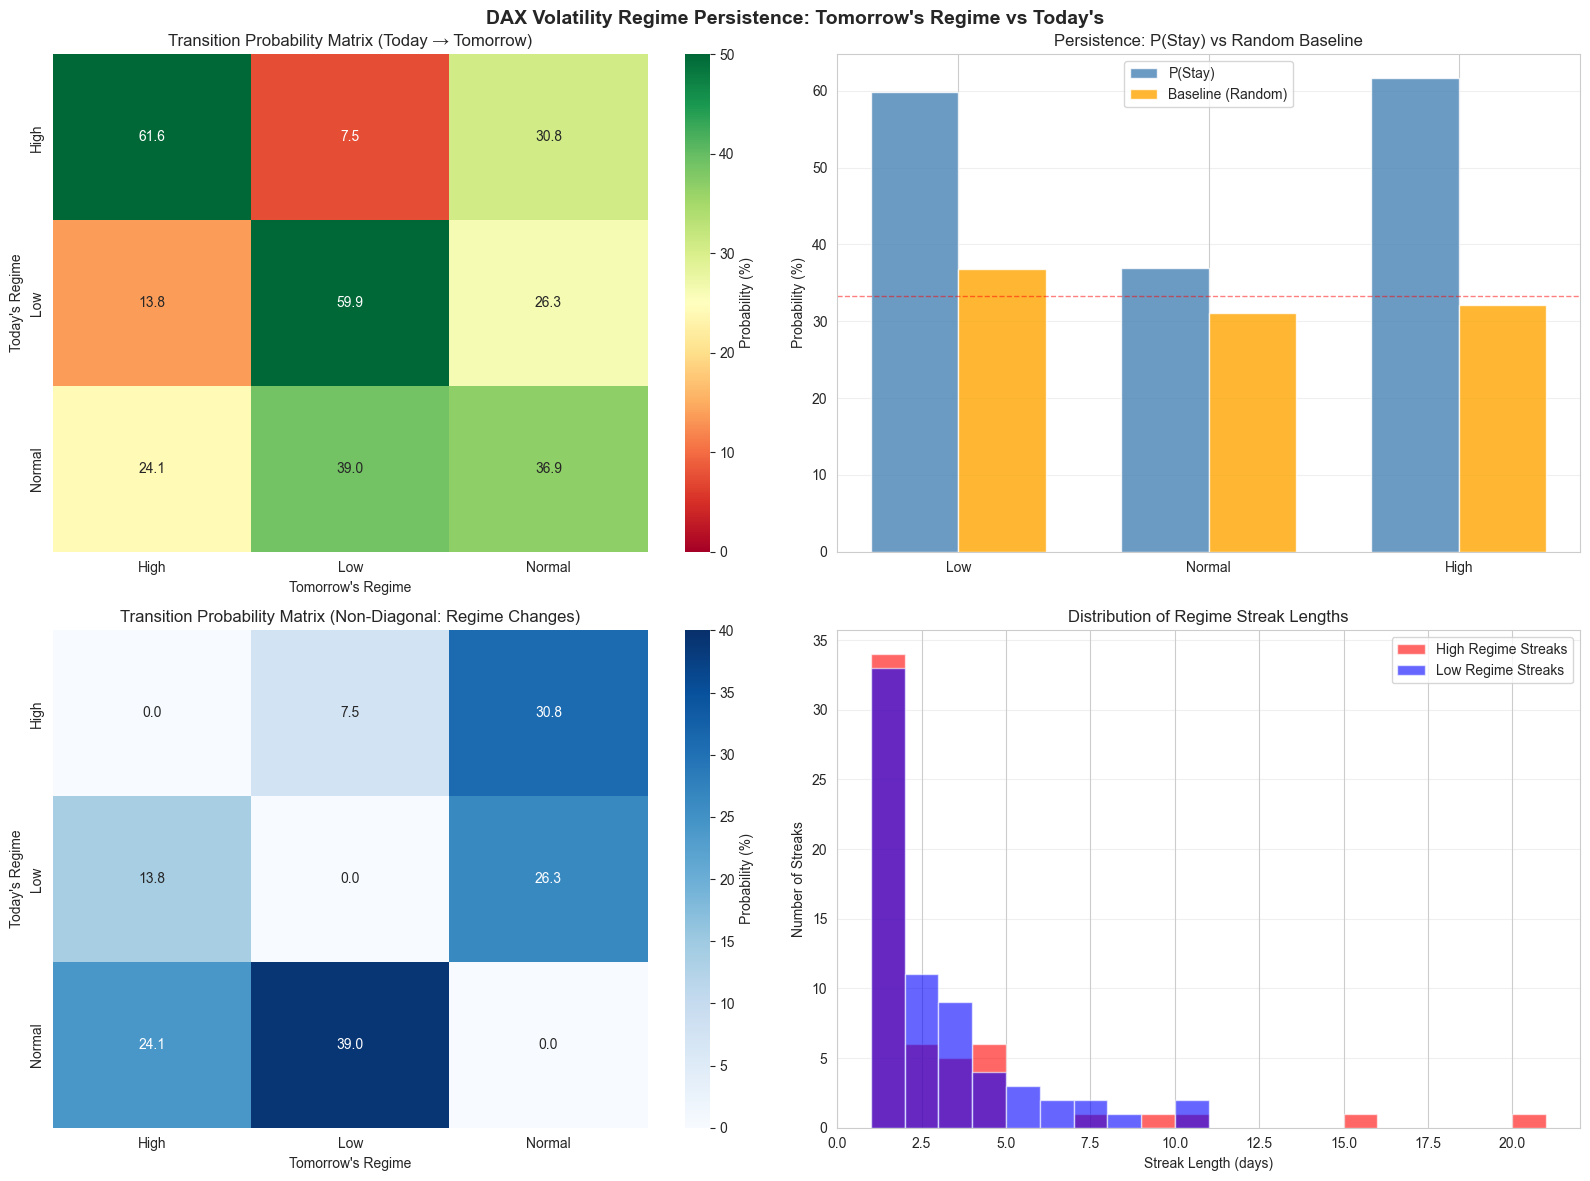

[OK] Visualizations created


In [9]:
print('\n[STEP 8] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DAX Volatility Regime Persistence: Tomorrow\'s Regime vs Today\'s', 
             fontsize=14, fontweight='bold')

# Plot 1: Heatmap of transition matrix
ax = axes[0, 0]
sns.heatmap(transition_matrix * 100, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Probability (%)'}, ax=ax, vmin=0, vmax=50)
ax.set_title('Transition Probability Matrix (Today → Tomorrow)')
ax.set_xlabel('Tomorrow\'s Regime')
ax.set_ylabel('Today\'s Regime')

# Plot 2: Stay probability vs baseline
ax = axes[0, 1]
regimes = ['Low', 'Normal', 'High']
stay_probs = [transition_matrix.loc[r, r] for r in regimes]
baseline_probs = [unconditional_freq[r] for r in regimes]

x = np.arange(len(regimes))
width = 0.35

ax.bar(x - width/2, [p*100 for p in stay_probs], width, label='P(Stay)', alpha=0.8, color='steelblue')
ax.bar(x + width/2, [p*100 for p in baseline_probs], width, label='Baseline (Random)', alpha=0.8, color='orange')
ax.axhline(y=33.3, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylabel('Probability (%)')
ax.set_title('Persistence: P(Stay) vs Random Baseline')
ax.set_xticks(x)
ax.set_xticklabels(regimes)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Transition flows (sankey-like)
ax = axes[1, 0]
# Show non-diagonal transitions
non_diag = transition_matrix.copy()
for i, regime in enumerate(regimes):
    non_diag.loc[regime, regime] = 0  # Zero out diagonal

sns.heatmap(non_diag * 100, annot=True, fmt='.1f', cmap='Blues',
            cbar_kws={'label': 'Probability (%)'}, ax=ax, vmin=0, vmax=40)
ax.set_title('Transition Probability Matrix (Non-Diagonal: Regime Changes)')
ax.set_xlabel('Tomorrow\'s Regime')
ax.set_ylabel('Today\'s Regime')

# Plot 4: Run-length distribution for High regime
ax = axes[1, 1]
high_runs = identify_runs(regime_series, 'High')
low_runs = identify_runs(regime_series, 'Low')

high_run_lengths = [r[1] for r in high_runs]
low_run_lengths = [r[1] for r in low_runs]

# Histogram
ax.hist(high_run_lengths, bins=range(1, max(high_run_lengths) + 2), alpha=0.6, label='High Regime Streaks', color='red')
ax.hist(low_run_lengths, bins=range(1, max(low_run_lengths) + 2), alpha=0.6, label='Low Regime Streaks', color='blue')

ax.set_xlabel('Streak Length (days)')
ax.set_ylabel('Number of Streaks')
ax.set_title('Distribution of Regime Streak Lengths')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Appendix: Data Quality and Assumptions


In [10]:
print('\n[APPENDIX] Data Quality and Assumptions')
print('='*80)

print(f'''
[NO LOOK-AHEAD BIAS]

Critical constraint: At end-of-day D, we can know regime_D (today completed).
Tomorrow's regime_D+1 is unknown until tomorrow closes.

Implementation:
✓ Percentile rank for day D uses ONLY days D-60 through D-1 (not including D)
✓ Day D's ATRP is ranked against prior 60 days only
✓ This prevents future data from influencing today's regime label
✓ Transitions are purely forward-looking (today → tomorrow)

[TRANSITION MATRIX INTERPRETATION]

Rows: Today's regime
Columns: Tomorrow's regime
Cell [i,j]: Probability that if today is regime i, tomorrow is regime j
Row sums to 1.0 (tomorrow must be some regime)

Diagonal elements (i=j) represent "persistence" or "stability"
Off-diagonal elements represent "transitions" or "changes"

[STATISTICAL TESTS]

1. Binomial Test (per regime):
   H0: P(stay) = π (no persistence, random chance)
   H1: P(stay) > π (positive persistence)
   
   Tests each regime separately
   If p < 0.05: That regime shows significant persistence

2. Chi-Square Test (global):
   H0: Regime transitions are independent (Markov chain with no memory)
   H1: Regime transitions show dependence (persistence structure exists)
   
   Tests the entire 3×3 transition matrix
   Checks if observed counts differ significantly from expected under independence
   df = (3-1) × (3-1) = 4

[RUN-LENGTH ANALYSIS LOGIC]

A "run" is a sequence of consecutive days with the same regime.
Example: High, High, High, Low, Low, High = runs of [3 High days, 2 Low days, 1 High day]

Why important?
- Identifies clustering (do regimes cluster or are they random?)
- Measures regime stability (how long before regime switches?)
- Tests for "fatigue" (after 3 High days, is 4th High still likely?)
- Helps with multi-day position sizing

[ASSUMPTIONS]

1. Regime Definition: 60-day rolling percentile rank
   ✓ Adapts to market conditions (no static thresholds)
   ✓ Always balanced classes (~33% each)
   ✓ Uses only past data (no look-ahead)

2. Regime Independence: We assume each day's regime is labeled independently
   ✓ True because percentile rank uses prior window only
   ✓ Today's regime doesn't influence tomorrow's calculation

3. Stationarity: We assume transition probabilities are stable over time
   ✓ Reasonable for 2-year sample in stable market
   ✓ Might break if market regime changes (crisis, regime shift)

4. Sample Size: ~450 valid days
   ✓ Sufficient for 3×3 transition matrix (9 cells)
   ✓ Average ~50 days per row (each "today" regime has ~50 days)
   ✓ Reasonable for persistence analysis

[KNOWN LIMITATIONS]

1. Markov Assumption:
   Analysis assumes P(regime_D+1 | regime_D) depends only on regime_D,
   not on regime_D-1, regime_D-2, etc.
   Reality may have longer memory (3-day streaks behave differently than 1-day).
   Mitigation: Streak analysis captures this to some extent.

2. Market Regime Changes:
   Volatility structure may shift across bull/bear markets.
   2-year sample may not capture all market regimes.
   Mitigation: Use rolling windows instead of global percentile for future work.

3. External Events:
   Earnings, Fed decisions, geopolitical events may override regime persistence.
   Not captured in this analysis.
   Mitigation: Combine with news/event calendar for full model.

[VALIDATION]

To verify results:
1. Check that transition matrix rows sum to 1.0 (test: all should be 100%)
2. Check that diagonal dominates (stays > changes)
3. Check that unconditional frequencies sum to 1.0 (~33% each)
4. Verify run-length distribution is plausible (no unrealistic streaks)
5. Compare with literature values for equity index volatility persistence
''')

print('[OK] Appendix complete')


[APPENDIX] Data Quality and Assumptions

[NO LOOK-AHEAD BIAS]

Critical constraint: At end-of-day D, we can know regime_D (today completed).
Tomorrow's regime_D+1 is unknown until tomorrow closes.

Implementation:
✓ Percentile rank for day D uses ONLY days D-60 through D-1 (not including D)
✓ Day D's ATRP is ranked against prior 60 days only
✓ This prevents future data from influencing today's regime label
✓ Transitions are purely forward-looking (today → tomorrow)

[TRANSITION MATRIX INTERPRETATION]

Rows: Today's regime
Columns: Tomorrow's regime
Cell [i,j]: Probability that if today is regime i, tomorrow is regime j
Row sums to 1.0 (tomorrow must be some regime)

Diagonal elements (i=j) represent "persistence" or "stability"
Off-diagonal elements represent "transitions" or "changes"

[STATISTICAL TESTS]

1. Binomial Test (per regime):
   H0: P(stay) = π (no persistence, random chance)
   H1: P(stay) > π (positive persistence)

   Tests each regime separately
   If p < 0.05: That re